<Axes: xlabel='Date'>

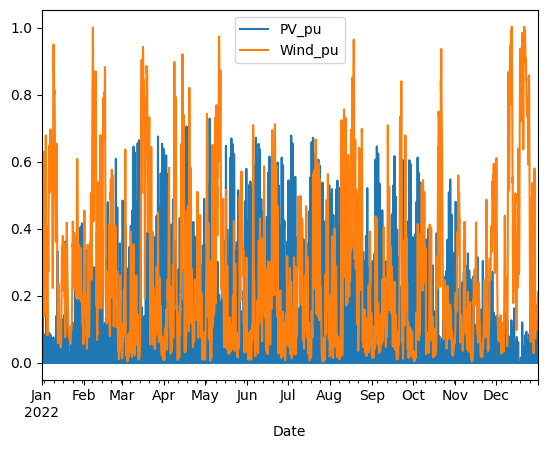

In [17]:
from common import DATA_DIR
import pandas as pd
from os.path import join

def prepare_district_dataframe(year=2017):
    '''
    Build a dataframe with the information of the district found
    in the first excel file found. By default searches the year 2017

    :param year: Year

    :return: Dataframe with the district energy demand info.
    '''
    EXCEL_DATA = join(DATA_DIR, "quartier1_2017.xlsx")

    start = str(year) + "-01-01"
    days = 365  # Full year

    # Correct for leap year
    if year % 4 == 0:
        days += 1

    # Set first the datetime objects with the appropriate dates
    dates = pd.date_range(start, periods=days * 24 + 1, freq="H")

    # Electricity
    electricity = pd.read_excel(EXCEL_DATA,
                                "electricity demand series",
                                engine='openpyxl')["DE01"][2:].tolist()

    # Heat
    heat = pd.read_excel(EXCEL_DATA, "heat demand series", engine='openpyxl')[
        "DE01"][2:].tolist()

    # PV Production per kW installed (as data source, no direct PV Modeling)
    pv_df = pd.read_excel(EXCEL_DATA, "volatile series", engine='openpyxl')

    # Data is on the 4th column
    pv_pu = pv_df[pv_df.columns[3]][2:].tolist()

    # Wind Production per kW installed (as data source, no direct WK Modeling)
    wind_df = pd.read_excel(EXCEL_DATA, "volatile series", engine='openpyxl')

    # Data is on the 5th column
    wind_pu = wind_df[wind_df.columns[4]][2:].tolist()

    # Complete the last hour so I get a full year.
    # Copy the last value for simplicity
    electricity.append(electricity[-1])
    heat.append(heat[-1])
    pv_pu.append(pv_pu[-1])
    wind_pu.append(wind_pu[-1])




    # Set the time resolution as 15 mins
    #district_df = district_df.resample("15T").pad()

    #incorporate electricity data
    electricity_data= join(DATA_DIR, "Germany.csv")
    df_electricity= pd.read_csv(electricity_data, parse_dates=True)

    df_electricity
    if year not in range(2015,2023):
        year=2022

    df_electricity = df_electricity[(df_electricity['Datetime (Local)'] > f"{year}-01-01") & (df_electricity['Datetime (Local)'] < f"{year+1}-01-01")]

    df_electricity = df_electricity[['Datetime (Local)',"Price (EUR/MWhe)"]]
    df_electricity.rename(columns={'Datetime (Local)':"Time", "Price (EUR/MWhe)":"Elec_Price"}, inplace=True)
    df_electricity.set_index("Time")  

    # Build Dataframe from a dictionary

    min_len = min(len(dates),
                len(electricity),
                len(heat),
                len(pv_pu),
                len(wind_pu),
                len(df_electricity["Elec_Price"])
                )
    district_data = {
        "Date": dates[0:min_len],
        "Electricity": electricity[0:min_len],
        "Heat": heat[0:min_len],
        "PV_pu": pv_pu[0:min_len],
        "Wind_pu": wind_pu[0:min_len],
        "Elec_price": df_electricity["Elec_Price"][0:min_len]}

    district_df = pd.DataFrame.from_dict(district_data)
    district_df.set_index("Date", inplace=True)


    # Remove the last value as it is for 01-Jan 00:00 of next year.
    return district_df[:-1]


df= prepare_district_dataframe(year=2022)

df[["PV_pu", "Wind_pu"]].plot()

<Axes: xlabel='Date'>

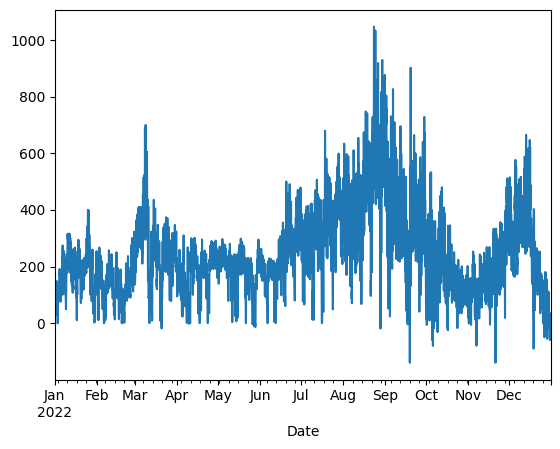

In [18]:
df["Elec_price"].plot()
